In [42]:
import numpy as np
import pandas as pd
import torch
import cv2
import sys
from utils import *
import matplotlib.pyplot as plt
import os
from scipy import linalg
from functools import reduce
from itertools import combinations
from skimage.measure import compare_ssim as ssim
from sklearn.metrics import mean_squared_error
import skimage
import re
import networks


import sys
from utils import *
import networks


def logGradient(img):
    """ Compute Gradients in the log domain.
        
        Given a numpy image (H,W,3) returns a Tensor (6,H,W) containing gradients in x- and y-direction.
    """
    img = np.float32(img)
    img = img +1
    img = np.log(img)

    h,w,c = img.shape
    xDev = np.array([[-1.0,1.0,0.0]])
    yDev = np.array([[-1],[1],[0]])
    laplacian = np.array([[0,-1,0],[-1,4,-1],[0,-1,-1]])
    img_x = cv2.filter2D(img,-1,xDev)
    img_y = cv2.filter2D(img,-1,yDev)
    #color_x = cv2.split(img_x)
    #color_y = cv2.split(img_y)
    img_x = transforms.ToTensor()(img_x)
    img_y = transforms.ToTensor()(img_y)
    grad = torch.cat([img_x,img_y])
    return grad

def GradientToImg(grad):
    """ Reconstructs an image given its gradients. """
    grad= grad.permute(1, 2, 0)
    grad = torch.split(grad,3,2)
    img_x = grad[0].numpy()
    img_y = grad[1].numpy()

    
    color_x = cv2.split(img_x)
    color_y = cv2.split(img_y)
    result = []
    
    h,w,c = img_x.shape
    xDev = np.array([[-1.0,1.0,0.0]])
    yDev = np.array([[-1],[1],[0]])
    laplacian = np.array([[0,-1,0],[-1,4,-1],[0,-1,-1]])
    
    for i in range(3):
        I_x = color_x[i]
        I_y = color_y[i]

        I = cv2.filter2D(I_x,-1,cv2.flip(xDev,-1)) + cv2.filter2D(I_y,-1,cv2.flip(yDev,-1))
        I = cv2.dft(I,flags = cv2.DFT_COMPLEX_OUTPUT)

        # Split complex matrix into real part A and imaginary part B
        A,B = cv2.split(I)

        # Prepare Deconvolution
        S = np.zeros((h,w))
        S[0,0]=4
        S[0,1]=-1
        S[1,0]=-1
        S[0,w-1]=-1
        S[h-1,0]=-1
        S = cv2.dft(S, flags = cv2.DFT_COMPLEX_OUTPUT)
        C, D = cv2.split(S)
        # Handling Zero-values
        zeroC = C==0
        zeroD = D==0
        zeros = zeroC & zeroD
        D[zeros] = 1 
        # Complex Division:
        Z = C*C + D*D
        Real = (A*C+B*D)/Z
        Imaginary = (B*C-A*D)/Z

        # Pseudo inverse
        Real[zeros] = 0
        Imaginary[zeros] = 0

        S = cv2.merge([Real,Imaginary])
        S = cv2.dft(S,flags = cv2.DFT_INVERSE+cv2.DFT_REAL_OUTPUT+cv2.DFT_SCALE)

        #S = np.exp(S-1)

        result.append(S)

    for i in range(3):
        i_min = np.min(result[i])
        i_max = np.max(result[i])
        result[i] = 255*(result[i]-i_min)/(i_max-i_min)
    S = cv2.merge(result)
    return S


In [49]:
def showImages(l):
    columns = len(l)
    plt.figure(figsize=(15,10),dpi=300)
    for i, img in enumerate(l):
        plt.subplot(1, columns, i + 1)
        img = np.int64(img)
        #img = img[...,::-1]
        plt.imshow(img)
        plt.axis('off')
    return

directory = os.listdir("D:250x250/")
files = os.listdir("D:250x250/")
match = lambda x: len(re.findall("img_\d+_\d.jpg", x))== 1
cut_string = lambda x: eval(re.sub("_.*","",re.sub("img_","",x)))

files = list(filter(match,files))
files = list(map(cut_string,files))
first,last = min(files),max(files)

def getImage(idx):
    file = "D:250x250/" + directory[idx]
    return cv2.imread(file)

def getImages(idx,n,resize=False):
    
    ground_truth_dir = "D:250x250/"
    img_files = None
    
    data_dir = "eval/"
    nrs = np.random.choice(range(1,10),n,False).tolist()
    img_files = [data_dir +  "img_" +str(idx)+ "_" + str(nr) + ".jpg" for nr in nrs]
    
    exists = all([os.path.isfile(img_file) for img_file in img_files])
    assert exists, "Id img_(%d).img does not exist or is incomplete" % (idx)

            
    label_file = ground_truth_dir + "books/img " + "("+str(idx - 1)+").jpg"
    label = cv2.imread(label_file)
    label = label[...,::-1]- np.zeros_like(label)


    imgs = [cv2.imread(file) for file in img_files]
    imgs = [img[...,::-1]- np.zeros_like(img) for img in imgs]

    if len(imgs[0].shape)==2:
        imgs = [cv2.cvtColor(img, cv2.COLOR_GRAY2BGR) for img in imgs]
        
    
    if resize:
        label = cv2.resize(label, dsize=(256,256))
        imgs = [ cv2.resize(img, dsize=(256,256)) for img in imgs]
    return label,imgs

    
    
def getRandomImage():
    return getImage(np.random.randint(0,len(directory)))

def shrinkage(M, eps):
    return np.sign(M)*np.maximum(np.abs(M)-eps,0)

def RPCA(imgs,lamb,iterations = 10, rank = 1):
    
    H,W,C = imgs[0].shape
    imgs = [img.flatten() for img in imgs]
    D =  np.float64(np.stack(imgs))
    
    A = np.zeros(D.shape)
    E = np.zeros(D.shape)
    
    Y = np.float64(np.sign(D))
    
    u, singulars, vh = np.linalg.svd(Y, full_matrices=False)
    J = singulars[0]
    J = np.max([J,np.max(Y)])
    Y = Y/J
    ###### TODO: adjust parameter lambda= 1/sqrt(max(m,n)) ######
    ###### TODO: Hyperparameter Optimization (Gridsearch) ######
    #lamb = 0.025 
    mu = 10*lamb
    rho = 1.5
    n = len(imgs)
    
    for i in range(iterations):
        X = D-E+Y/mu
        #singulars,u,vt = cv2.SVDecomp(X)
        u, singulars, vt = np.linalg.svd(X, full_matrices=False)
        for k in range(rank,n):
            singulars[k] = 0.0
        
        singulars = shrinkage(singulars,1.0/mu)
        
        A = u.dot(np.diag(singulars.flatten())).dot(vt)
        E = shrinkage(D-A+Y/mu,lamb)
        Y = Y + mu*((D-A)-E)
        mu = mu*rho
    
  
    return A,E


#showSeq(createSequence(3,img,compose(createShadow,createSpecularity)))
def hist_norm(source, template):
    # source: https://stackoverflow.com/questions/32655686/histogram-matching-of-two-images-in-python-2-x
    olddtype = source.dtype
    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)
    interp_t_values = interp_t_values.astype(olddtype)

    return interp_t_values[bin_idx].reshape(oldshape)

# Markdown

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=True)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        out += x
        return out
    
class DilatedResidualBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dilation):
        super(DilatedResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=1, dilation=dilation, padding=dilation, bias=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, dilation=dilation,padding=dilation, bias=True)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        out += x
        return out
        
class DeepSetNet(nn.Module):
    """ Deep Set Residual Neural Network """
    def __init__(self, encoder_num_blocks=10, decoder_num_blocks=10, smooth_num_blocks=6, planes=32,block=ResidualBlock ):
        super(DeepSetNet, self).__init__()
        self.planes = planes
        self.input = nn.Conv2d(3, self.planes, kernel_size=3, stride=1, padding=1, bias=True)
        self.output= nn.Conv2d(self.planes, 3, kernel_size=3, stride=1, padding=1, bias=True)
        
        
        # Create a down-/up-sampling architecture
        self.downsample = []
        self.upsample = []
        n = planes
        for i in range(2):
            self.downsample.append( nn.Conv2d(in_channels = n, out_channels=n*2, kernel_size=3, stride=2, padding=1 ) )
            self.downsample.append(nn.ReLU(inplace=True))

            
            self.upsample = [nn.ReLU(inplace=True)] + self.upsample
            self.upsample = [nn.ConvTranspose2d(in_channels=n*2, out_channels=n, kernel_size=3, stride=2, padding=1, output_padding=1)] + self.upsample
            n *= 2

        self.downsample = nn.Sequential(*self.downsample)
        self.upsample = nn.Sequential(*self.upsample)
        
        
        # Embedding of downsampled features
        self.encoder = self._make_layer(block, n, encoder_num_blocks)
        self.decoder = self._make_layer(block, n, decoder_num_blocks)
        self.smooth  = self._make_smooth_layer(planes, smooth_num_blocks)
        
    def _make_layer(self, block, planes, num_blocks):
        layers = []
        for i in range(num_blocks):
            layers.append(DilatedResidualBlock(planes, planes,2))
        return nn.Sequential(*layers)
    
    def _make_smooth_layer(self, planes, num_blocks):
        layers = []
        dilation = 1
        for i in range(num_blocks):
            layers.append(DilatedResidualBlock(planes,planes,dilation))
            if i%2 == 0:
                dilation *= 2
        layers.append( nn.Conv2d(in_channels = planes, out_channels=planes, kernel_size=3, stride=1, padding=1 ) )
        layers.append(nn.ReLU(inplace=True))
        layers.append( nn.Conv2d(in_channels = planes, out_channels=planes, kernel_size=3, stride=1, padding=1 ) )
        return nn.Sequential(*layers)
            
        

    def forward(self, x):
        """Forward pass of our DeepSet Network 
        
        x: of tensor of size (B, S, C, H, W)
        """

        xs = torch.split(x,1,dim = 1)
        xs = [torch.squeeze(x,dim=1) for x in xs]
        embedding = [self.encoder(self.downsample(self.input(x))) for x in xs]
        embedding = torch.stack(embedding).mean(0)
        out = self.output(self.smooth(self.upsample(self.decoder(embedding))))

        
        return out
 

In [31]:
device = torch.device("cuda:0")
deep_set_gan = DeepSetNet(encoder_num_blocks=10, decoder_num_blocks=5, planes=18)
deep_set_gan.load_state_dict(torch.load("modelsGAN/" + "/nn.pt"))
root_dir ="D:/250x250/"

evaluation_set = list(range(213033,214033))

In [22]:
img_files = ["eval/" +  "img_" +str(idx)+ "_" + str(nr) + ".jpg" for idx in evaluation_set for nr in range(1,10)]
print("All files exist in the evaluation set: "+str(all([os.path.isfile(file) for file in img_files])))

All files exist in the evaluation set: True


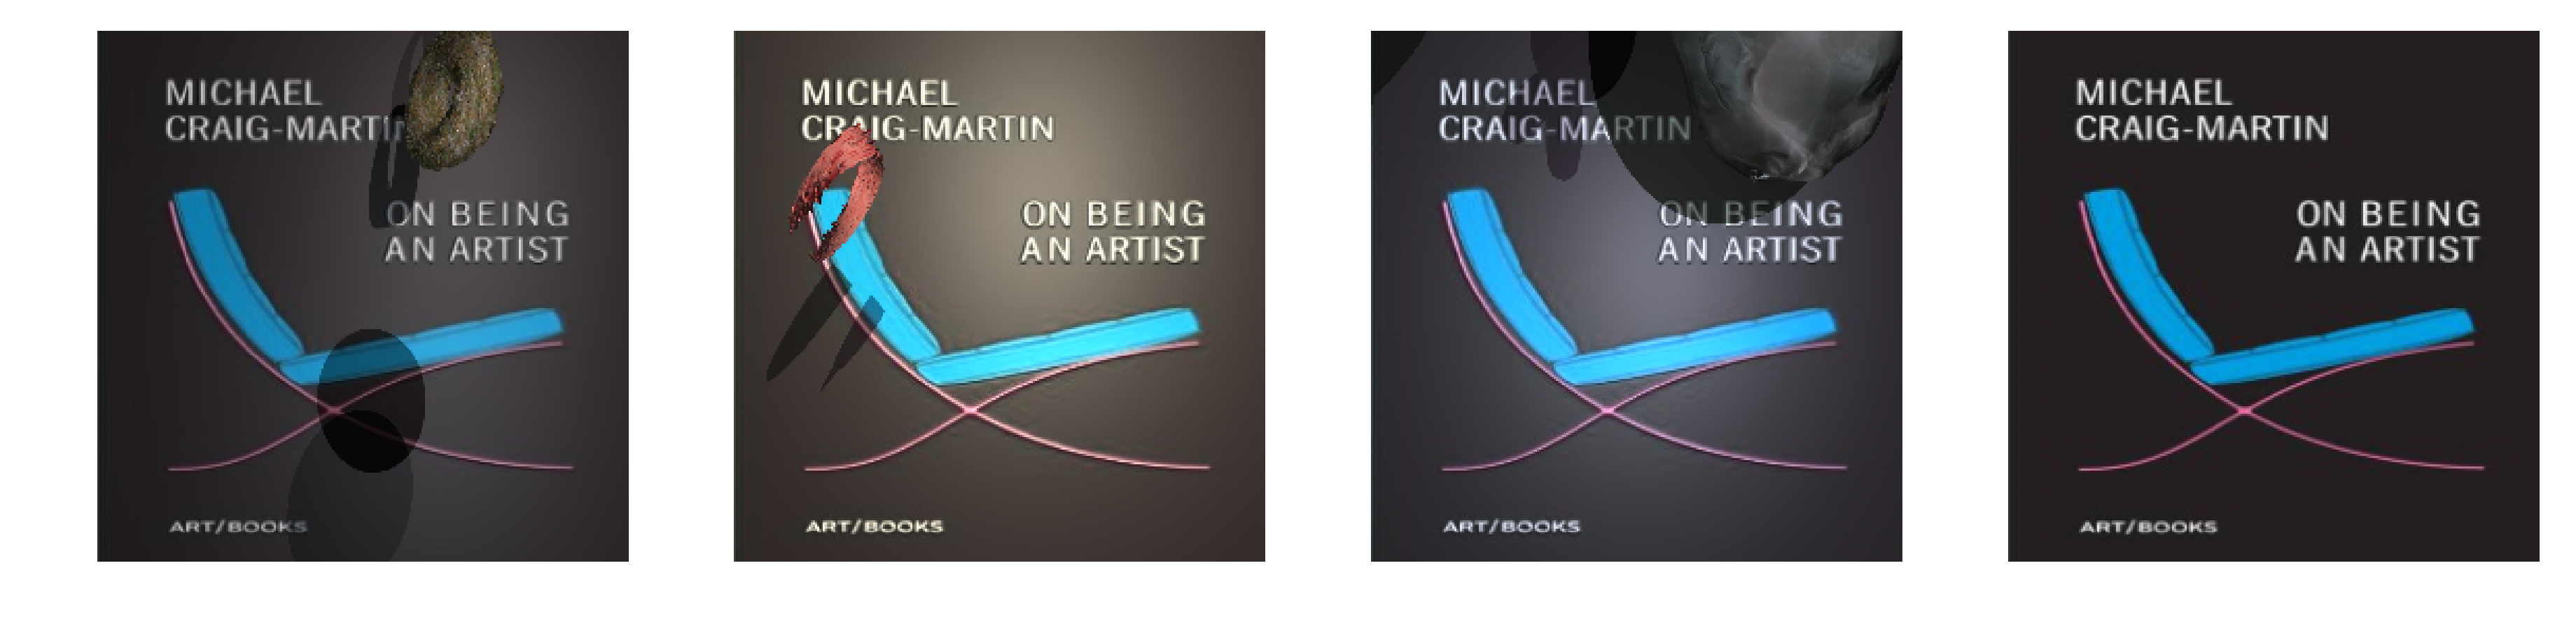

In [54]:
label, imgs = getImages(evaluation_set[0],3, resize=True)
showImages(imgs+[label])

In [70]:
def applyNet(net,imgs, mode = "linear",reduce = "avg"):
    imgs = [transforms.ToTensor()(img) for img in imgs]
    device = torch.device("cuda:0")

        
    n = 0
    
    input_size = None
    if isinstance(list(net.children())[0], nn.Conv2d):
        input_size = int(list(net.children())[0].in_channels/3)
    else:
        input_size = int(list(net.children())[0][1].in_channels/3)

    if input_size>len(imgs):
        return np.zeros((imgs[0].shape[1],imgs[0].shape[2],3))
    res = []
    
    if mode == "comb":
        iterator = combinations(imgs, input_size)
    if mode == "linear":
        iterator = [(imgs[i:i+input_size]) for i in range(len(imgs)-input_size+1)]
        
    for combo in iterator:
        data = torch.cat(combo,0)
        data = data.to(device)
        data = data.unsqueeze(0)
        out = net(data)
        out = out.cpu().detach()

        _,C,H,W = out.size()
        out = out.view(C,H,W) 
        out = torch.clamp(out,0,1)
        out = out.permute(1, 2, 0)

        res.append(out)
    
    if len(res)==1:
        result = res[0]
        result = result.numpy()
        result = np.int32(result*255)
        return result

    if reduce == "no":
        result = [ np.uint8(out.numpy()*255) for out in res]
        return result
    
    stack = torch.stack(res).numpy()
    if reduce == "median":
        result = np.median(stack,0)
        result = np.int32(result*255)
        return result


    if reduce == "avg":
        result = np.mean(stack,0)
        result = np.int32(result*255)
        return result
    
def applyDeepSet(net,imgs):
    imgs = [transforms.ToTensor()(img) for img in imgs]
    imgs = torch.unsqueeze(torch.stack(imgs),0)
    img = deep_set_gan(imgs).detach()

    _,C,H,W = img.size()
    img = img.view(C,H,W) 
    img = img.clamp(0,1)
    img = img.permute(1, 2, 0)

    img = img.numpy()
    img = np.int32(img*255)
    return img

def Weiss(imgs):
    
    border = 10
    imgs = [cv2.copyMakeBorder(i,border,border,border,border,0) for i in imgs]
    imgs = [logGradient(img) for img in imgs]
    stack = torch.stack(imgs).numpy()
    result = torch.Tensor(np.median(stack,0))
    result = GradientToImg(result)
    result = result[10:-10,10:-10]
    return result
    
    
def AvgImgs(imgs):
    result = np.zeros(imgs[0].shape)
    for img in imgs:
        result +=img
    return result/len(imgs)
        
def TensorToImg(img):
    _,C,H,W = img.size()
    img = img.view(C,H,W) 
    return img

def SSIM_norm(x,y):

    y = np.uint8(y)    
    x = np.uint8(x)

    x = hist_norm(x,y)
    y = np.uint8(y)    
    x = np.uint8(x)
    return ssim(x,y,gaussian_weights=True, multichannel=True)

def MSE_norm(x,y):
    y = np.int32(y)    
    x = np.int32(x)

    x = hist_norm(x,y)
    y = np.float32(y)    
    x = np.float32(x)
    return np.mean((x-y)**2)

def PSNR_norm(x,y):

    y = np.uint8(y)    
    x = np.uint8(x)
    x = hist_norm(x,y)
    y = np.uint8(y)    
    x = np.uint8(x)
    return skimage.measure.compare_psnr(x,y)

def SSIM(x,y):

    y = np.uint8(y)    
    x = np.uint8(x)
    return ssim(x,y,gaussian_weights=True, multichannel=True)

def MSE(x,y):
    y = np.float32(y)    
    x = np.float32(x)
    return np.mean((x-y)**2)

def PSNR(x,y):

    y = np.uint8(y)    
    x = np.uint8(x)
    return skimage.measure.compare_psnr(x,y)


compose = lambda *F: reduce(lambda f, g: lambda x: f(g(x)), F)



def Evaluate(testset,n,metrics,metrics_name,models,models_name, iterations=10):
    
    root_dir = "D:250x250/"
    errors = []
    ids = []
    nr_images = []
    for idx in testset:
        for i in range(iterations):
            
            results = []
#             img = getImage(idx)
#             imgs = CreateSequence(n,img,transform)
            label_file = root_dir + "books/img " + "("+str(first + idx - 1)+").jpg"
    
            img = None
            imgs = None
            try:
                img,imgs = getImages(idx,n,resize=True)  
            except AssertionError:
                break

            
            results = [f(imgs) for f in models]

            error = [metric(res,img) for metric in metrics for res in results]
            errors.append(error)
            ids.append(idx+first)
            nr_images.append(n)
            
            
    columns = [metric + "_" + model for metric in metrics_name for model in models_name]
    df = pd.DataFrame.from_records(errors,columns=columns)
    
    df["id"] = ids
    df["Images"] = nr_images
    return df

def crossValidation(testset, n_images=5, iterations = 5):
    dfs=[]
    metrics = [SSIM,MSE,PSNR,SSIM_norm,MSE_norm,PSNR_norm]
    metrics_name = ["SSIM","MSE","PSNR","SSIM_norm","MSE_norm","PSNR_norm"]

    

    f1  = lambda imgs: np.median(np.asarray(imgs), axis=0)  
    f2  = lambda imgs: AvgImgs(imgs)
    f3  = lambda imgs: Weiss(imgs)
    f4  = lambda imgs: np.reshape(RPCA(imgs,53,30)[0][0,:],(256,256,3))
    f5  = lambda imgs: applyDeepSet(deep_set_gan,imgs)

    models = [f1,f2,f3,f4,f5]
    models_name = ["Median","AVG","Weiss","RPCA", "DeepSetGan"]
    
    ### GAN-Evaluation ###
    #models = [f13,f14,f15,f16]
    #models_name = ["GAN AVG", "GAN Med", "GAN_norm AVG", "GAN_norm Med"]
    
    for n in range(1,n_images+1):
        print("Evaluate on "+str(n)+ " images")
        df = Evaluate(testset,n,metrics,metrics_name,models,models_name,iterations)
        dfs.append(df)
        df.to_csv("Evaluation_DeepSetGAN"+ str(n) + ".csv")
        #df.to_csv("Evaluation3D_GAN_"+ str(n) + ".csv")

    return pd.concat(dfs)

In [72]:
df = crossValidation(evaluation_set,9,3)
df.to_csv("Evaluation_DeepSetGAN_all.csv")

Evaluate on 1 images
Evaluate on 2 images
Evaluate on 3 images
Evaluate on 4 images
Evaluate on 5 images
Evaluate on 6 images
Evaluate on 7 images
Evaluate on 8 images
Evaluate on 9 images


In [69]:
y, imgs = getImages(evaluation_set[0],5, True)
np.reshape(RPCA(imgs,53,30)[0][0,:],(256,256,3)).shape

(256, 256, 3)